# Buy or sell at close

# 1. Import data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.simplefilter("ignore")
import time
import openpyxl

In [2]:
data = pd.read_csv('Final_BN_2018_15m.csv')
data.drop('Unnamed: 0',axis = 1,inplace = True)

In [3]:
data

,DATE_TIME,SCRIP,OPEN,HIGH,LOW,CLOSE
0,2018-01-01 09:15:00,BANKNIFTY,25566.45,25588.00,25496.55,25551.70
1,2018-01-01 09:30:00,BANKNIFTY,25552.75,25573.95,25538.85,25551.50
2,2018-01-01 09:45:00,BANKNIFTY,25551.70,25555.30,25537.15,25546.90
3,2018-01-01 10:00:00,BANKNIFTY,25542.90,25574.25,25537.90,25561.50
4,2018-01-01 10:15:00,BANKNIFTY,25563.65,25573.25,25556.20,25561.20
...,...,...,...,...,...,...
6120,2018-12-31 14:15:00,BANKNIFTY,27168.00,27197.40,27161.20,27175.15
6121,2018-12-31 14:30:00,BANKNIFTY,27175.10,27196.85,27163.15,27169.30
6122,2018-12-31 14:45:00,BANKNIFTY,27167.45,27186.70,27159.85,27172.30
6123,2018-12-31 15:00:00,BANKNIFTY,27172.50,27179.90,27141.60,27159.05


# 2. Strategy

1. Sell Entry: When 2nd candle crosses high of 1st candle, sell when price crosses the low of 2nd candle 
   Stop loss: high of 2nd candle

2. Buy Entry: When 2nd candle crosses low of 1st candle, buy when price crosses the high of 2nd candle 
   Stop loss: low of 2nd candle

3. Target: Run till 03:15 PM

# 3. Trade Identification

In [4]:
df = data.copy()

In [5]:
df.drop('SCRIP',axis=1,inplace = True)

In [6]:
df['BUY_TRIG'] = 0
df['BUY_SL'] = 0
df['SELL_TRIG'] = 0
df['SELL_SL'] = 0

In [7]:
candle_I = df[df['DATE_TIME'].str.contains('09:15')]   #09:15 AM candle 
candle_I.reset_index(inplace = True)

In [8]:
candle_II = df[df['DATE_TIME'].str.contains('09:30')]   #09:30 AM candle 
candle_II.reset_index(inplace = True)

In [9]:
#Identify sell trades
H1 = candle_I[candle_I['HIGH'] <= candle_II['HIGH']]   #When the 2nd candle breaks the high of 1st candle,
                                                  #sell when next candles breaks low of 2nd candle with SL: high of 2nd candle

In [10]:
H2 = candle_II[candle_I['HIGH'] <= candle_II['HIGH']]

In [11]:
#Identify buy trades
L1 = candle_I[candle_I['LOW'] > candle_II['LOW']]   #When 2nd candle breaks 1st candle low, 
                                                 #buy when other candles break 2nd candle high, SL: 2nd candle low

In [12]:
L2 = candle_II[candle_I['LOW'] > candle_II['LOW']]


# 4. Generating buy and sell triggers

In [13]:
#Sell triggers
H2['SELL_TRIG'] = H2['LOW']
H2['SELL_SL'] = H2['HIGH']
H2.set_index('index',inplace = True)

In [14]:
#Buy Triggers 
L2['BUY_TRIG'] = L2['HIGH']
L2['BUY_SL'] = L2['LOW']
L2.set_index('index',inplace = True)

# 5. Generating Trade signals
    0: No trade
    1: Buy
    2: Already in buy
    3: Buy Exit
    -1: Sell
    -2: Already in sell
    -3: Sell Exit

In [15]:
signal = pd.concat([L2,H2])
signal

,DATE_TIME,OPEN,HIGH,LOW,CLOSE,BUY_TRIG,BUY_SL,SELL_TRIG,SELL_SL
index,,,,,,,,,
26,2018-01-02 09:30:00,25371.25,25373.80,25281.90,25325.30,25373.80,25281.90,0.00,0.00
51,2018-01-03 09:30:00,25408.15,25412.65,25382.25,25387.40,25412.65,25382.25,0.00,0.00
126,2018-01-08 09:30:00,25714.45,25757.85,25686.30,25749.50,25757.85,25686.30,0.00,0.00
176,2018-01-10 09:30:00,25669.90,25669.90,25626.65,25647.80,25669.90,25626.65,0.00,0.00
201,2018-01-11 09:30:00,25552.30,25567.45,25532.25,25542.40,25567.45,25532.25,0.00,0.00
...,...,...,...,...,...,...,...,...,...
5801,2018-12-12 09:30:00,26380.70,26468.20,26374.40,26443.60,0.00,0.00,26374.40,26468.20
5851,2018-12-14 09:30:00,26777.80,26874.35,26769.75,26849.05,0.00,0.00,26769.75,26874.35
5951,2018-12-20 09:30:00,27198.25,27219.10,27186.40,27215.10,0.00,0.00,27186.40,27219.10


In [17]:
if signal.index.duplicated().sum() !=0:   #drop duplicates due to lower timeframe
    signal.drop_duplicates(subset = 'DATE_TIME',keep ='first',inplace = True)

In [19]:
df[['BUY_TRIG','BUY_SL','SELL_TRIG','SELL_SL']] = signal[['BUY_TRIG','BUY_SL','SELL_TRIG','SELL_SL']]   #merge it with main df

In [20]:
df

,DATE_TIME,OPEN,HIGH,LOW,CLOSE,BUY_TRIG,BUY_SL,SELL_TRIG,SELL_SL
0,2018-01-01 09:15:00,25566.45,25588.00,25496.55,25551.70,NaN,NaN,NaN,NaN
1,2018-01-01 09:30:00,25552.75,25573.95,25538.85,25551.50,NaN,NaN,NaN,NaN
2,2018-01-01 09:45:00,25551.70,25555.30,25537.15,25546.90,NaN,NaN,NaN,NaN
3,2018-01-01 10:00:00,25542.90,25574.25,25537.90,25561.50,NaN,NaN,NaN,NaN
4,2018-01-01 10:15:00,25563.65,25573.25,25556.20,25561.20,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6120,2018-12-31 14:15:00,27168.00,27197.40,27161.20,27175.15,NaN,NaN,NaN,NaN
6121,2018-12-31 14:30:00,27175.10,27196.85,27163.15,27169.30,NaN,NaN,NaN,NaN
6122,2018-12-31 14:45:00,27167.45,27186.70,27159.85,27172.30,NaN,NaN,NaN,NaN
6123,2018-12-31 15:00:00,27172.50,27179.90,27141.60,27159.05,NaN,NaN,NaN,NaN


In [21]:
df.fillna(0,inplace = True)

In [22]:
#For filling buy trigger and buy SL
for i in range(0,df.shape[0],25):
    buy_trig = df[df['DATE_TIME'].str.contains('09:30')]['BUY_TRIG'][i+1]
    buy_sl = df[df['DATE_TIME'].str.contains('09:30')]['BUY_SL'][i+1]
    if buy_trig != 0:
        df['BUY_TRIG'][i+1:i+25] = buy_trig
        df['BUY_SL'][i+1:i+25] = buy_sl

In [23]:
#For filling sell trigger and sell SL
for i in range(0,df.shape[0],25):
    sell_trig = df[df['DATE_TIME'].str.contains('09:30')]['SELL_TRIG'][i+1]
    sell_sl = df[df['DATE_TIME'].str.contains('09:30')]['SELL_SL'][i+1]
    if buy_trig != 0:
        df['SELL_TRIG'][i+1:i+25] = sell_trig
        df['SELL_SL'][i+1:i+25] = sell_sl

In [24]:
df['ENTRY_SIG'] = 0
df['EXIT_SIG'] = 0

In [25]:
#Entry Signal

for i in range(1,df.shape[0]):
    
    if df['BUY_TRIG'][i] != 0:

        if df['ENTRY_SIG'][i-1] != 0:
            df['ENTRY_SIG'][i] = df['ENTRY_SIG'][i-1] 
    
            if (df['HIGH'][i] > df['BUY_TRIG'][i]) & (df['ENTRY_SIG'][i-1] == 1):
                df['ENTRY_SIG'][i] = 2
            
            if (df['CLOSE'][i] < df['BUY_SL'][i]) & (df['ENTRY_SIG'][i-1] == 2): 
                df['ENTRY_SIG'][i] = 1
        else:
            df['ENTRY_SIG'][i] = 1

            
    elif df['SELL_TRIG'][i] != 0:
        
        if df['ENTRY_SIG'][i-1] != 0:
            df['ENTRY_SIG'][i] = df['ENTRY_SIG'][i-1] 
                
            if (df['LOW'][i] < df['SELL_TRIG'][i]) & (df['ENTRY_SIG'][i-1] == -1):
                df['ENTRY_SIG'][i] = -2

            if (df['CLOSE'][i] > df['SELL_SL'][i]) & (df['ENTRY_SIG'][i-1] == -2): 
                df['ENTRY_SIG'][i] = -1
        else:
            df['ENTRY_SIG'][i] = -1

            
    else:
        df['ENTRY_SIG'][i] = 0

In [26]:
df['EXIT_SIG'] = 0

In [27]:
#Exit signal
for i in range(1,df.shape[0]):
    
    df['EXIT_SIG'][i] = 0
        
    if df['ENTRY_SIG'][i] > 0:  #For buy position exit
        if df['ENTRY_SIG'][i] < df['ENTRY_SIG'][i-1]:
            df['EXIT_SIG'][i] = 3   #Exit buy
        if df['DATE_TIME'][i].find('15:15') > 0:
            if df['ENTRY_SIG'][i] == 2:
                df['EXIT_SIG'][i] = 3   #Exit buy at 15:15  
        
    if df['ENTRY_SIG'][i] < 0:  #For sell position exit
        if df['ENTRY_SIG'][i] > df['ENTRY_SIG'][i-1]:
             df['EXIT_SIG'][i] = -3   #Exit sell
        if df['DATE_TIME'][i].find('15:15') > 0:
            if df['ENTRY_SIG'][i] == -2:
                df['EXIT_SIG'][i] = -3   #Exit sell at 15:15      

In [28]:
df['ENTRY_PRICE'] = 0

In [29]:
#Entry Price
for i in range(1,df.shape[0]):
    
    df['ENTRY_PRICE'][i] = 0
    
    if (df['ENTRY_SIG'][i] > 0) & (df['ENTRY_SIG'][i-1] > 0):  #For buy position 
        if df['ENTRY_SIG'][i] > df['ENTRY_SIG'][i-1]:
            df['ENTRY_PRICE'][i] = -df['CLOSE'][i]    #Negative price for buy position


    if (df['ENTRY_SIG'][i] < 0) & (df['ENTRY_SIG'][i-1] < 0): #For sell position
        if df['ENTRY_SIG'][i] < df['ENTRY_SIG'][i-1]:
            df['ENTRY_PRICE'][i] = df['CLOSE'][i]     #Positive price for sell position


In [30]:
df['EXIT_PRICE'] = 0

In [31]:
#Exit Price
for i in range(1,df.shape[0]):
    
    df['EXIT_PRICE'][i] = 0
    
    if df['EXIT_SIG'][i] == 3:  #buy Exit
        df['EXIT_PRICE'][i] = df['CLOSE'][i]
    
    if df['EXIT_SIG'][i] == -3:  #buy Exit
        df['EXIT_PRICE'][i] = -df['CLOSE'][i]

In [32]:
#Trade Price 
df['TRADE'] = df['ENTRY_PRICE'] + df['EXIT_PRICE'] 

In [68]:
df['PNL'] = 0

In [69]:
#PNL
for i in range(25,df.shape[0]+1,25):
    
    df['PNL'][i-1] = df['TRADE'][i-25:i].sum()

# 6. Backtest Result Calculation

In [70]:
result = df.copy()

In [71]:
daily_PNL = result[result['DATE_TIME'].str.contains('15:15')][['DATE_TIME','PNL']]
daily_PNL.reset_index(drop = True,inplace = True)

In [72]:
total_trade_days = (daily_PNL['PNL'] != 0).sum()
total_trade_days

121

In [73]:
daily_dd = daily_PNL[daily_PNL['PNL'] != 0]
daily_dd.reset_index(drop = True,inplace = True)

In [74]:
daily_dd['dd'] = 0

In [75]:
for i in range(1,daily_dd.shape[0]):
    if daily_dd['PNL'][i] + daily_dd['dd'][i-1] > 0:
        daily_dd['dd'][i] = 0
    else:
        daily_dd['dd'][i] = daily_dd['PNL'][i] + daily_dd['dd'][i-1]

In [76]:
cum_PNL = pd.DataFrame(daily_PNL['PNL'].cumsum())
cum_PNL.reset_index(drop = True,inplace = True)

# 7. Plot the cumulative PNL and drawdown

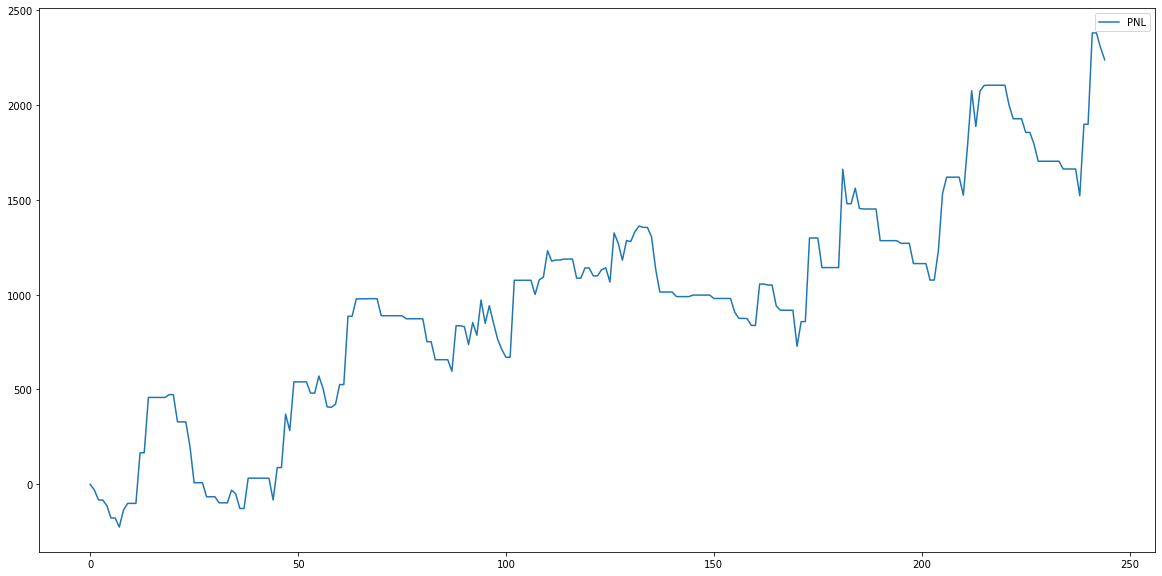

In [77]:
plt.rcParams["figure.figsize"] = (20,10)
cum_PNL.plot()

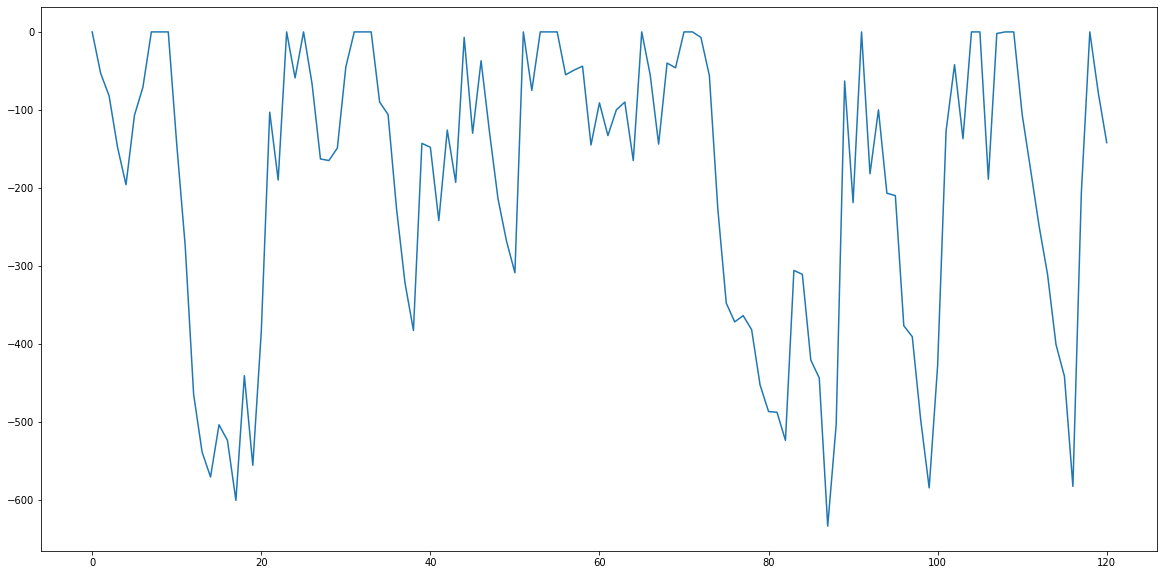

In [78]:
plt.rcParams["figure.figsize"] = (20,10)
daily_dd['dd'].plot()

# 8. General Strategy Stats

In [79]:
avg_theoritical_points_per_trade = round((cum_PNL.iloc[-1]/total_trade_days)[0],2)
avg_theoritical_points_per_trade

18.5

In [80]:
avg_practical_points_per_trade = round((avg_theoritical_points_per_trade - 8 - 4),2)  #Subtract slippages and brokerage
avg_practical_points_per_trade

6.5

In [81]:
total_points_per_year = round(avg_practical_points_per_trade*total_trade_days,2)
total_points_per_year 

786.5

In [82]:
max_profit_per_trade = daily_PNL['PNL'].max()
max_profit_per_trade 

519

In [83]:
max_loss_per_trade = daily_PNL['PNL'].min()
max_loss_per_trade 

-191

In [84]:
positive_trades = (daily_PNL['PNL'] > 0).sum()
positive_trades

49

In [85]:
negative_trades = (daily_PNL['PNL'] < 0).sum()
negative_trades

72

In [86]:
zero_trades = (daily_PNL['PNL'] == 0).sum()
zero_trades

124

In [87]:
win_ratio = (positive_trades)/(positive_trades + negative_trades)
win_ratio

0.4049586776859504

In [88]:
max_drawdown = abs(daily_dd['dd'].min())
max_drawdown

634

In [89]:
max_loss = max_drawdown*20
max_loss

12680

In [90]:
margin =  30000

In [91]:
trading_capital_per_lot = margin + max_loss
trading_capital_per_lot

42680

In [92]:
ROI = round((total_points_per_year*20)*100/trading_capital_per_lot, 2)
ROI

36.86

In [93]:
loss_percent = round((max_loss)*100/trading_capital_per_lot, 2)
loss_percent

29.71

In [94]:
calmar_ratio = round((ROI/loss_percent),2)
calmar_ratio

1.24

In [95]:
result['capital'] = 0
result['capital'][0] = trading_capital_per_lot

In [96]:
for i in range(1,result.shape[0]):
    if result['PNL'][i] != 0:
        result['capital'][i] = result['capital'][i-1] + (result['PNL'][i]-10)*20
    else:
        result['capital'][i] = result['capital'][i-1]

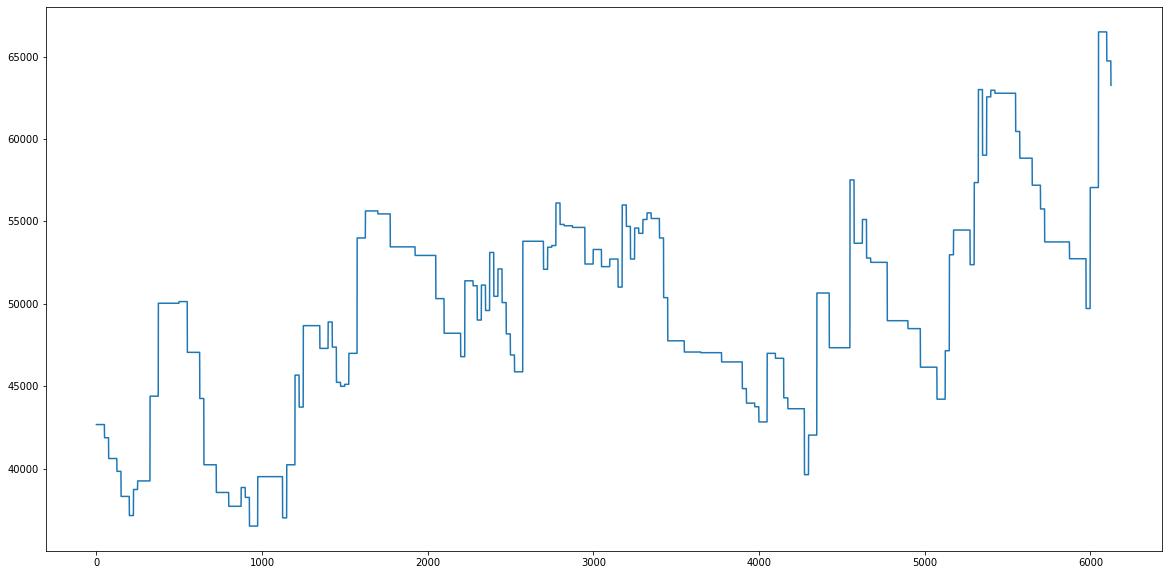

In [97]:
plt.rcParams["figure.figsize"] = (20,10)
result['capital'].plot()

In [98]:
KPI = {'avg_theoritical_points_per_trade':avg_theoritical_points_per_trade,'avg_practical_points_per_trade':avg_practical_points_per_trade,'total_points_per_year':total_points_per_year,'max_profit_per_trade':max_profit_per_trade,'max_loss_per_trade':max_loss_per_trade,'positive_trades':positive_trades,'negative_trades':negative_trades,'win_ratio':win_ratio,'max_drawdown':max_drawdown,'max_loss':max_loss,'ROI':ROI,'loss_percent':loss_percent,'calmar_ratio':calmar_ratio,'trading_capital_per_lot':trading_capital_per_lot}

In [99]:
pd.options.display.float_format = "{:,.2f}".format

In [100]:
strategy_stats = pd.DataFrame(KPI.values(),index = KPI.keys(),columns = ['Values'])
strategy_stats

,Values
avg_theoritical_points_per_trade,18.50
avg_practical_points_per_trade,6.50
total_points_per_year,786.50
max_profit_per_trade,519.00
max_loss_per_trade,-191.00
positive_trades,49.00
negative_trades,72.00
win_ratio,0.40
max_drawdown,634.00
max_loss,"12,680.00"


# 9. Save results to excel file

In [101]:
with pd.ExcelWriter('results/result_and_stats_2018_ver2.1.0_15m.xlsx') as writer:  
    result.to_excel(writer,sheet_name = 'trades')
    strategy_stats.to_excel(writer,sheet_name = 'stats')

# Strategy Checks:

# 1. Linear Curve
# 2. Average points per trade
# 3. Max DD
# 4. ROI
# 5. Calmar ratio

# If all above checks are fine, then select strategy based on calmar ratio and strategies with fewer number of trades